In [1]:
import numpy as np

np.__version__

'1.26.4'

s [1 0 0 1]
c [0 0 0 1 0 0 0 0 0]


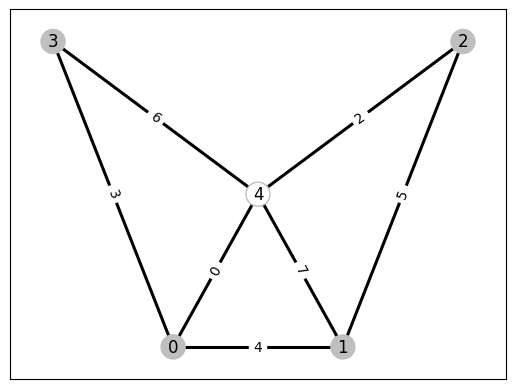

In [2]:
from pymatching import Matching
import matplotlib.pyplot as plt

Hx = np.array([[1, 1, 0, 1, 1, 0, 0, 0, 0],
               [0, 0, 0, 0, 1, 1, 0, 1, 1],
               [0, 0, 1, 0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, 0, 0, 1, 0, 0]])


matching = Matching(Hx)

noise = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0])
s = Hx @ noise % 2 # correctly evaluates to [1, 0, 0, 1]
print("s", s)
c = matching.decode(s) # correctly predicts [0, 0, 0, 1, 0, 0, 0, 0, 0]
print("c", c)

matching.draw()
plt.show()

In [1]:
# reload magic 
%load_ext autoreload

In [2]:
import stim
import numpy as np

In [3]:
def index_vertex(x, y, L):
    return x + y * L


def num_pauli_to_str(idx, n, paulitype):
    """
    Convert a number to a string of Pauli operators.
    """
    pauli = ["_"] * n
    for i in idx:
        pauli[i] = paulitype
    return "".join(pauli)

def generate_rotated_surface_code_stabilizers(L):
    """
    construct the set of stabilizers for the rotated toric code having periodic boundary conditions.

    Tiling numbering scheme, e.g. L=3
            Z
         0 --- 1 --- 2
         |  X  |  Z  | X
         3 --- 4 --- 5
       X |  Z  |  X  |        <--- THIS IS A QUANTUM COMPUTER. 
         6 --- 7 --- 8
                  Z
    Returns:
        x_stabilizers: list of r_x total stim.PauliString objects representing the X stabilizers
        z_stabilizers: list of r_z total stim.PauliString objects representing the Z stabilizers
        H_x: PCM for x stabilizers, (r_x, n) matrix
        H_z: PCM for z stabilizers, (r_z, n) matrix
    """
    x_stabilizers = []
    z_stabilizers = []
    n = L**2  # total number of qubits in the standard toric code layout

    # For each vertex (x, y), define a star operator: product of X on the 4 edges touching that vertex.
    # Edges: (x,y) horiz, (x-1,y) horiz, (x,y) vert, (x,y-1) vert, all mod L for periodic BCs.

    for x in range(L):
        for y in range(L):
            v1 = index_vertex(x, y, L)
            if x == L - 1 or y == L - 1:
                continue
            v2 = index_vertex(x, (y + 1), L)
            v3 = index_vertex((x + 1), y, L)
            v4 = index_vertex((x + 1), (y + 1), L)
            vertices = [v1, v2, v3, v4]
            if ( x + y ) % 2 == 0:
                ptype = "X"
                x_stabilizers.append(vertices)
            else:
                ptype = "Z"     
                z_stabilizers.append(vertices)

    # top and bottom
    for x in range(L):
        if x < L - 1:
            ptype = "Z"
            if x % 2 == 0 :
                v1 = index_vertex(x, 0, L)
                v2 = index_vertex(x + 1, 0, L)
                z_stabilizers.append([v1, v2])
            elif x % 2 == 1:
                v1 = index_vertex(x, L - 1, L)
                v2 = index_vertex(x + 1, L - 1, L)
                z_stabilizers.append([v1, v2])

    for y in range(L):
        if y < L - 1:
            ptype = "X"
            if y % 2 == 1:
                v1 = index_vertex(0, y, L)
                v2 = index_vertex(0, y + 1, L)
                x_stabilizers.append([v1, v2])
            elif y % 2 == 0:
                v1 = index_vertex(L - 1, y, L)
                v2 = index_vertex(L - 1, y + 1, L)
                x_stabilizers.append([v1, v2])
    H_x = np.zeros((len(x_stabilizers), n), dtype=int)
    for i, js in enumerate(x_stabilizers):
        H_x[i, js] = 1
    H_z = np.zeros((len(z_stabilizers), n), dtype=int)
    for i, js in enumerate(z_stabilizers):
        H_z[i, js] = 1
    z_stabilizers = [num_pauli_to_str(stabilizer, n, "Z") for stabilizer in z_stabilizers]
    z_stabilizers = [stim.PauliString(stabilizer) for stabilizer in z_stabilizers]
    x_stabilizers = [num_pauli_to_str(stabilizer, n, "X") for stabilizer in x_stabilizers]
    x_stabilizers = [stim.PauliString(stabilizer) for stabilizer in x_stabilizers]

    return x_stabilizers, z_stabilizers, H_x, H_z


In [4]:
L = 3
xs, zs, Hx, Hz = generate_rotated_surface_code_stabilizers(L)


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag


def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with
    lattice size L, constructed as the hypergraph product of
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)



In [6]:
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag
def toric_code_x_logicals(L):
    """
    The logical operator is X...X either horizontally or vertically across the lattice, in the unrotated version.
    In the rotated version 
    """
    if L != 3:
        raise NotImplementedError("Only L=3 is implemented")
    vertical_x = [1]*L + [0]*L*(L - 1)
    _x = ([1] + [0]*(L-1)) * L
    return np.array([
        [1, 0, 0, 1, 0, 0, 1, 0, 0], # vertical left edge.
        [1, 0, 0, 0, 1, 0, 0, 0, 1], # diagonal from top left to bottom right
    ])



In [8]:
import pymatching
print(pymatching.__version__)

AttributeError: module 'pymatching' has no attribute '__version__'

s [1 0 0 1]
c [0 0 0 0 0 0 0 0 0]


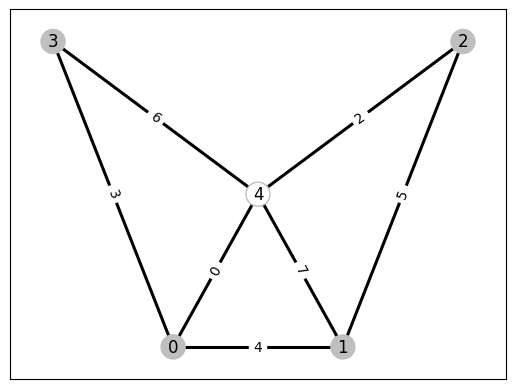

In [9]:
("""
            
         0 --- 1 --- 2
         |  X  |     | X
         3 --- 4 --- 5
       X |     |  X  |        <--- qubit numbering and X stabilizers 
         6 --- 7 --- 8
                  
    
""")
# OKAY IM A FUCKING IDIOT, WE NEED TO BE NUMBERING THE SQUARES, NOT THE QUBITS!
# see fig 5: https://arxiv.org/pdf/2307.14989
from pymatching import Matching
# generate a matching object specific to the PCM for x-stabilizers
matching_x = Matching(Hx)
print("PCM for x-stabilizers, L=3 rotated surface code")
print(Hx)
# matching = Matching.from_check_matrix(Hx, use_virtual_boundary_node=True)
matching = Matching(Hx)
print(matching)
noise = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0]) # Z error on qubit '3'
print("z noise:", noise)
s = Hx @ noise % 2
print("syndrome:", s)
c = matching.decode(s)
print("predicted logical error:", c)

# x_logicals = toric_code_x_logicals(L)
# logical_flip_pred = x_logicals @ c % 2
# logical_flip_true = x_logicals @ noise % 2
# print("true logical error:", logical_flip_true)
# print("predicted logical error:", logical_flip_pred)

PCM for x-stabilizers, L=3 rotated surface code
[[1 1 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 1 1]
 [0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 1 0 0]]
<pymatching.Matching object with 4 detectors, 1 boundary node, and 7 edges>
z noise: [0 0 0 1 0 0 0 0 0]
syndrome: [1 0 0 1]
predicted logical error: [0 0 0 0 0 0 0 0 0]


In [135]:
from pymatching import Matching
# generate a matching object specific to the PCM for x-stabilizers
matching_x = Matching(Hx)

# The noise we care about deepends _only_ on the z-type pauilis occuring the error string
# i.e. if an error E = [ e_x e_z ] in binary symplectic form, then Hx only 'sees' e_z
p = 0.1
# for my project, this will just go over all possible errors :)
# z_noise = np.random.binomial(1, p, size=Hx.shape[1])
z_noise = np.array([0, 0, 0, 1, 0, 0, 0, 0, 0])
z_syndrome = Hx @ z_noise % 2
print("Z noise:", z_noise)

# generate a prediction and predict logical error
prediction = matching_x.decode(z_syndrome)
x_logicals = toric_code_x_logicals(L)
logical_error_pred = x_logicals @ prediction % 2
logical_error_true = x_logicals @ z_noise % 2

print("Prediction: ", prediction)
print("True logical obs flipped: ", logical_error_true)
print("Predicted logical obs flipped: ", logical_error_pred)


Z noise: [0 0 0 1 0 0 0 0 0]
Prediction:  [0 0 0 0 0 0 0 0 0]
True logical obs flipped:  [1 0]
Predicted logical obs flipped:  [0 0]


In [20]:
print("z_syndrome", z_syndrome)
print("z error", z_noise_component)

z_syndrome [1 1 1 1]
z error [0 0 0 1 0 1 0 0 0]


In [7]:
t = stim.Tableau.from_stabilizers(stabilizers, allow_redundant=True, allow_underconstrained=True)
# we leave out the final stabilizer that canonically represents the degree of 
# freedom for a state we didn't specify
generators_S = [t.z_output(k) for k in range(len(t) - 1)]
generators_T = [t.x_output(k) for k in range(len(t) - 1)]
generators_L = [stim.PauliString(p*L) for p in ["I", "X"]]

In [ ]:
from mldec.utils import pauli_decoding_stim
p_I = 0.99
n = L ** 2
k = 1
temp = []
pvec = [p_I, (1-p_I)/3, (1-p_I)/3, (1-p_I)/3]
error_channel = lambda x: pauli_decoding_stim.pauli_vector_channel(pvec, x, n)
p_SA = pauli_decoding_stim.compute_coset_distribution_pure_errors(generators_S, generators_T, generators_L, error_channel)

mle = pauli_decoding_stim.mle_success_prob(p_SA)
print("Maximum likelihood, L={}".format(L))
print(mle)


8 9 1


Maximum likelihood, L=3
0.9397690759087137


In [11]:
from itertools import chain, combinations
from functools import reduce
def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
        


In [15]:
enumerate(powerset([1,2,3]))

#### what we need is:
1. answers for MLE on every syndrome -> separates good and bad
2. for all "good" syndromes, we need answers from pymatching.

#### build the parity check matrices

so MWPM decoding for X-type and Z-type errors is the same process (PCM might be different), so our procedure is:
1. get the syndrome logical pair $(\sigma, \ell)$
2. Check that $f^*(\sigma) = \ell$, so we know we have a good example
3. Let $\sigma = [\sigma_X | \sigma_Z]$
4. MWPM decode $\sigma$ into $\ell_X \ell_Z = \hat{\ell}$, our guess for the logical operator
5. if $\hat{\ell} \notin \ell \mathcal{S}$, then we have an important example

Issues:
 - organizing everything might be tough; do we start with $\ell$
 - idea: I build the prism from the ground up; I could run MWPM at each layer before generating $\ell \mathcal{S}$, then check equality as I fill out that coset
 - probably need to downgrade to numpy 1.26

In [19]:
import numpy as np
from scipy.sparse import hstack, kron, eye, csc_matrix, block_diag


def repetition_code(n):
    """
    Parity check matrix of a repetition code with length n.
    """
    row_ind, col_ind = zip(*((i, j) for i in range(n) for j in (i, (i+1)%n)))
    data = np.ones(2*n, dtype=np.uint8)
    return csc_matrix((data, (row_ind, col_ind)))


def toric_code_x_stabilisers(L):
    """
    Sparse check matrix for the X stabilisers of a toric code with
    lattice size L, constructed as the hypergraph product of
    two repetition codes.
    """
    Hr = repetition_code(L)
    H = hstack(
            [kron(Hr, eye(Hr.shape[1])), kron(eye(Hr.shape[0]), Hr.T)],
            dtype=np.uint8
        )
    H.data = H.data % 2
    H.eliminate_zeros()
    return csc_matrix(H)



In [ ]:
toric_code